# Annotation Error Detection
## IMD3011 - Datacentric AI
### [Dr. Elias Jacob de Menezes Neto](https://docente.ufrn.br/elias.jacob)


> Parts of this notebook were adapted from the amazing [MIT Introduction to Data-Centric AI](https://dcai.csail.mit.edu) course taugh by the amazing folks from [Cleanlab](https://cleanlab.ai/)

## Keypoints

- **Annotation Error Detection (AED):** AED is a process for automatically identifying mislabeled or inconsistent examples in datasets. It employs two types of methods: binary flaggers that simply mark errors and scorers that assign confidence score indicating error likelihood.

- **Types of Label Noise:** Label noise can occur in various forms:
  - **Uniform (Symmetric) Noise:** Every mislabel is equally likely.
  - **Systematic (Asymmetric) Noise:** Some classes are more likely to be confused than others.
  - **Instance-Dependent Noise:** The probability of mislabeling varies with specific features of each instance.

- **Label Noise Transition Matrix:** This matrix quantifies the probability of an observed noisy label given the true label. It is foundational to methods such as Confident Learning that adjust for label noise during training.

- **Retagging Approach:** Retagging uses predictions from a held-out (out-of-sample) model to identify and correct potential mislabels. By comparing model outputs with existing labels, it refines the training data, reducing annotation errors and potentially improving overall model performance.

- **Model Confidence and Thresholding:** Establishing class-specific confidence thresholds (using measures like calibration plots and averaged model predictions) allows the system to flag examples whose predicted probabilities deviate significantly from expectations. This helps isolate and quantify erroneous instances.

- **Data- vs. Model-Centric Methods:** While model-centric methods address noise by modifying the loss function (e.g., importance reweighting and loss correction), data-centric methods focus on identifying and cleaning the training data, an approach that is especially valuable in weak supervision settings.

- **Impact of Noisy Labels:** Noisy labels can significantly degrade model performance by misleading the learning process—models may learn incorrect associations, overfit on noise, and yield skewed performance metrics during evaluation.

- **Uncertainty in Predictions:** The discussion distinguishes between aleatoric uncertainty (irreducible noise due to built-in data randomness) and epistemic uncertainty (stemming from the limitations of the model). Properly handling both types is key to diagnosing errors and refining labels.

## Learning goals
By the end of this class, you will be able to:

1. **Explain** the key concepts of label noise and annotation error detection, including the distinctions between uniform, systematic (asymmetric), and instance-dependent noise.

2. **Analyze** the mathematical frameworks basic noisy label modeling, such as joint probability distributions, label noise transition matrices, and confidence thresholding.

3. **Apply** data-centric and model-centric methodologies—including retagging and confident learning approaches—to automatically identify, quantify, and correct mislabeled examples in datasets.

4. **Apply** practical pipelines using tools like Scikit-learn, TfidVectorizer, and Cleanlab to preprocess data, compute calibration plots, and construct confusion matrices for evaluating AED techniques.

5. **Evaluate** the effects of annotation errors on model performance and interpretation, and **propose** strategies that utilize thresholds, cross-validation, and error-set analysis to mitigate label noise in real-world scenarios.

6. **Design** iterative data curation workflows that integrate AED, retagging, and confident learning methods to enhance the quality of datasets for training sturdy machine learning models.

<p align="center">
<img src="images/wsl04_01.png" width="80%" height="80%" />
</p>

## Notation for Noisy Labels

Understanding the notations used in discussions about noisy labels and their true counterparts is important for grasping the basic concepts. This section introduces key symbols and definitions that help describe the relationship between observed labels and true labels regarding label noise.

### Key Notations and Definitions

- **$\tilde{y}$**  
  This symbol represents the **observed label**, which might contain errors due to noise in the data collection process.

- **$y^*$**  
  This denotes the **true label** (also called the latent or correct label). The true label is what the observed label $\tilde{y}$ should be if no mistakes occurred during data collection.



### Sets and Counts

The following notations help describe and quantify the relationship between noisy observed labels and true labels:

- **$X_{\tilde{y}=i,\, y^*=j}$**  
  This set contains all examples for which the observed label is $i$ and the true label is $j$. Analyzing these sets allows you to identify patterns of labeling errors.

- **$C_{\tilde{y}=i,\, y^*=j}$**  
  This count represents the number of instances in the set $X_{\tilde{y}=i,\, y^*=j}$. These counts are essential for calculating the distribution of label noise.



### Probabilities and Distributions

A statistical description of noisy labels requires modeling the probabilities of various label outcomes. Two key concepts are:

- **Joint Probability Distribution**  
  The joint probability $p(\tilde{y}=i,\, y^*=j)$ is defined as the probability that an instance is observed with label $i$ and its true label is $j$. This is computed by normalizing the counts:
  
  $$
  p(\tilde{y}=i,\, y^*=j) = \frac{C_{\tilde{y}=i,\, y^*=j}}{N}
  $$
  
  where $N$ is the total number of instances in the dataset.

- **Transition Probability**  
  The conditional probability $p(\tilde{y}=i \mid y^*=j)$ indicates the probability that an instance with true label $j$ is observed as label $i$. It quantifies the chance of mislabeling:
  
  $$
  p(\tilde{y}=i \mid y^*=j) = \frac{C_{\tilde{y}=i,\, y^*=j}}{C_{y^*=j}}
  $$
  
  where
  
  $$
  C_{y^*=j} = \sum_{k} C_{\tilde{y}=k,\, y^*=j}
  $$
  
  represents the total number of instances with true label $j$.

> **Important:**  
> Distinguishing between $\tilde{y}$ and $y^*$ allows us to adjust our models to account for label noise. Understanding and estimating the transition probability $p(\tilde{y}=i \mid y^*=j)$ is particularly useful for designing systems that can correct for or mitigate the impact of labeling errors.


### Practical Example: Animal Image Classification

<p align="center">
<img src="images/ai_cat_dog_meme.png" width="40%" height="40%" />
</p>

Consider a dataset of images where each image is labeled with an animal category (e.g., cats, dogs, horses). Due to mislabeling during data collection, some images of cats might be labeled as dogs. Here’s how the notations apply:

- **Noisy Label ($\tilde{y}$)**: The label given during data collection (e.g., "dog" for a misclassified cat image).
- **True Label ($y^*$)**: The actual category to which the image belongs (e.g., "cat").

For an image of a cat that has been mislabeled:

- **$X_{\tilde{y}=\text{dog},\, y^*=\text{cat}}$**: This set contains images that were observed as "dog" but are actually "cat."
- **$C_{\tilde{y}=\text{dog},\, y^*=\text{cat}}$**: This count is incremented for each instance where an image is misclassified from "cat" to "dog."

Using the counts across the entire dataset, you can compute the joint distribution

$$
p(\tilde{y}=i,\, y^*=j)
$$

and the transition probabilities

$$
p(\tilde{y}=i \mid y^*=j)
$$

This approach helps in quantifying the impact of noise, ultimately guiding improvements in model performance through techniques such as noise-aware training methods.


## Sources of Noisy Labels

Noisy labels occur due to various issues that can arise during data collection, processing, or annotation. Understanding these sources is key to mitigating their impact on model performance. This section explores common causes of label noise in datasets and their consequences for machine learning applications.


### 1. Human Error

- **Accidental Mislabeling:**  
  During the annotation process, an annotator might select the wrong label by mistake (e.g., clicking an incorrect button in the interface).

- **Fatigue or Inattention:**  
  Extended periods of labeling can lead to decreased concentration, resulting in oversight or mistakes.

- **Lack of Domain Expertise:**  
  Annotators who are not familiar with the specific subject matter may misclassify instances due to insufficient knowledge of the nuances involved.

*Example:* In a clinical diagnosis dataset, non-expert annotators might confuse similar medical conditions, leading to noisy labels.


### 2. Measurement Issues

- **Faulty Data Collection Tools:**  
  Inaccurate or poorly calibrated instruments can compromise the quality of the gathered data, leading to erroneous labels.

- **Inconsistent Measurement Approaches:**  
  Variability in data collection protocols or methodologies can introduce discrepancies. For example, differing guidelines across locations or time periods can result in inconsistent labeling.

*Example:* Temperature sensors with calibration issues may record incorrect values, affecting the labels in a weather dataset.


### 3. Algorithmic Errors

- **Error Propagation from Earlier Models:**  
  When labels are generated or refined using machine learning models (e.g., within a weak supervision pipeline), mistakes made by those models can be carried forward. This phenomenon is often seen when predictions from a preliminary model are used to label large datasets.

- **Biases in Automated Labeling:**  
  Algorithms may have innate biases or flaws that lead to systematic mislabeling, particularly when the training data of the automated process is itself noisy or unrepresentative.

*Example:* An automated system trained on biased historical data might over-represent certain categories while under-representing others, thus skewing the label distribution.


### 4. Data Corruption

- **Technical Glitches:**  
  Errors during data storage, transfer, or processing (e.g., software bugs or hardware failures) can corrupt labels.

- **Malicious Tampering:**  
  In some scenarios, datasets may be intentionally manipulated, either for competitive advantage or due to security breaches, resulting in label inaccuracies.

*Example:* A distributed database might experience data corruption during synchronization, leading to mismatches between the true state and the recorded labels.


### 5. Subjective Interpretations

- **Ambiguity in Labeling:**  
  Certain cases might not have a clear-cut category, and different annotators could assign different labels based on their interpretation. Such ambiguity can lead to inconsistent or noisy labels.

- **Cultural or Contextual Variations:**  
  Labelers from different cultural or contextual backgrounds might interpret data differently, especially in areas like sentiment analysis or image categorization.

*Example:* When annotating social media posts for sentiment, one annotator might label a sarcastic remark as positive while another could interpret it as negative, leading to noise in the training labels.


## Label Flipping and Noisy Labels

Label flipping happens when an instance is assigned an incorrect label, effectively swapping its true class with another. This concept is key to understanding how label errors, or *noisy labels*, can influence machine learning models.

### Examples of Label Flipping

- **Visual Misclassification:** An image depicting a bus is incorrectly labeled as a car.
- **Sentiment Analysis Error:** A review with a positive tone such as "Muito bom, gostei bastante!" is mistakenly tagged as negative.
- **NER Mislabeling:** A named entity like "Elias Jacob" is sometimes left untagged or assigned an incorrect category.



## Quantifying Label Noise

One way to quantify label noise is by using a confusion matrix that compares the true labels, $ y^* $, with the observed, or noisy, labels, $ \tilde{y} $.

> **Confusion Matrix Interpretation:**
>
> - **Diagonal elements:** The count of instances correctly labeled.
> - **Off-diagonal elements:** The count of label flips (mislabeled instances).

Consider the following confusion matrix:


<div align="center">

| $ C_{\tilde{y}, y^*} $ | $ y^* = \text{bus} $ | $ y^* = \text{car} $ | $ y^* = \text{bike} $ |
|--------------------------|------------------------|------------------------|------------------------|
| $ \tilde{y} = \text{bus} $   | 90                   | 35                   | 25                   |
| $ \tilde{y} = \text{car} $   | 50                   | 70                   | 5                    |
| $ \tilde{y} = \text{bike} $  | 30                   | 15                   | 75                   |
</div>

<br><br>
For instance, notice that 50 instances with the true label "bus" have been misclassified as "car". This matrix helps in visualizing the extent and pattern of label noise in dataset labels.



## Impact of Noisy Labels

Noisy labels can negatively affect the training and performance of machine learning models in several ways:

- **Model Performance:** Inaccurate labels can reduce model accuracy and hurt its ability to generalize to unseen data.
- **Training Challenges:** The model may end up fitting the noise, making it difficult to identify true patterns in the data.
- **Evaluation Concerns:** Test sets with noisy labels might lead to misleading assessments of model performance.
- **Bias Introduction:** Systematic labeling errors can introduce or worsen bias within the model.
- **Wasted Resources:** Training on datasets with label noise may result in inefficient use of computational time and resources.


## Understanding Uncertainty in Predictions

In machine learning, **uncertainty** indicates the extent to which a model lacks confidence in its predictions. It highlights the possibility of model errors and helps assess the reliability of outputs. Two primary types of uncertainty influence model predictions:

### 1. Aleatoric Uncertainty

- **Definition:** This uncertainty is due to innate randomness or noise present in the data. It is considered irreducible because it originates from the data-generation process.
- **Example:** In predicting house prices, factors such as sudden market variations or minor differences in property features contribute to aleatoric uncertainty. Even with extensive data, predicting the exact price is challenging because of these unavoidable variations.

### 2. Epistemic Uncertainty

- **Definition:** This uncertainty comes from limitations in the model's understanding of the relationship between inputs and outputs. It reflects the gap in the model’s knowledge and can be reduced by improving the model, such as by including more extensive or diverse training examples.
- **Example:** Consider a model trained primarily on images of adult cats and dogs. When faced with images of kittens or puppies, the model may show higher uncertainty because these examples were not well-represented in the training data.



## Disentangling Label Noise and Uncertainty

In practical scenarios, distinguishing whether errors stem from label noise (related to aleatoric uncertainty) or from the model's limitations (linked to epistemic uncertainty) is not straightforward. To address this, researchers often introduce a **label noise process assumption**.

### Class-Conditional Label Noise Model

A common assumption is that the label noise depends only on the true class label and not on other features of the input. This assumption can be described by:

$$
p(\tilde{y} \mid y^*; x) = p(\tilde{y} \mid y^*)
$$

where:

- $ \tilde{y} $ is the observed (possibly incorrect) label,
- $ y^* $ is the true label,
- $ x $ represents the input features.

This model implies that for all data points belonging to the same true class, the probability of a label flip follows the same pattern, regardless of individual differences in the input features. The transition probabilities $ p(\tilde{y} \mid y^*) $ can be organized into a matrix similar to the confusion matrix shown earlier. This helps in isolating the effects of noisy labels from the shortcomings related to the model's current design or training data.


## Types of Label Noise in Machine Learning

Label noise can considerably affect model performance. It is important to recognize the different types of label noise to build models that can handle or correct these errors. The three primary types are **uniform (symmetric) noise**, **systematic (asymmetric) class-conditional noise**, and **instance-dependent noise**.





### 1. Uniform (Symmetric) Label Noise

**Definition:**  
Uniform label noise assumes that for any instance with the true label $ y^* $, the probability of it being mislabeled as any other label is the same across all incorrect options. Formally, for any incorrect label $ i $ and true label $ j $:

$$
p(\tilde{y} = i \mid y^* = j) = \epsilon, \quad \forall \, i \neq j
$$

where $ \epsilon $ is the noise rate.

**Characteristics:**

- **Simplicity:** It is the most straightforward noise model.
- **Uniform Distribution:** Errors are assumed to be uniformly distributed among all classes.
- **Baseline Model:** Frequently used as a baseline in studies that focus on building noise-reliable techniques.

**Consequences:**

- **Modeling:** Easy to model and can serve as an initial test case.
- **Limitations:** This model might not capture the error patterns observed in real-world datasets, where mislabeling often shows bias toward certain classes.

> **Note:** Although common in research settings, this model may oversimplify the complexity of noise in practical applications.


### 2. Systematic (Asymmetric) Class-Conditional Label Noise

**Definition:**  
Systematic noise allows the mislabeling probabilities to vary between different class pairs. The probability of a mislabel depends on the true label $ y^* $ and can vary for each incorrect label $ i $:

$$
p(\tilde{y} = i \mid y^* = j) = \epsilon_{ij}
$$

with different values of $ \epsilon_{ij} $ for each pair $ (i, j) $.

**Characteristics:**

- **Realism:** More closely reflects actual noise in many datasets.
- **Error Patterns:** Often represents common misclassification trends, such as confusion between visually similar classes.

**Consequences:**

- **Complexity:** Modeling these probabilities requires a more complex approach.
- **Effectiveness:** Better captures the nuances in data labeling processes.
  
For example, in an animal image classification task, a cat might be more frequently misclassified as a dog rather than as a bird, reflecting a higher $p(\tilde{y} = \text{dog} \mid y^* = \text{cat})$ than $p(\tilde{y} = \text{bird} \mid y^* = \text{cat})$.

### 3. Instance-Dependent Label Noise

**Definition:**  
Instance-dependent noise takes into account both the true class $ y^* $ and the specific features $ x $ of the instance. The probability of an incorrect label is represented as:

$$
p(\tilde{y} = i \mid y^* = j, x)
$$

**Characteristics:**

- **Detail-Oriented:** It considers the attributes of individual samples, meaning that noise levels can vary across instances from the same class.
- **Complexity:** This model is the most detailed and can better mimic real-world scenarios where certain features make an instance more likely to be mislabeled.

**Consequences:**

- **Modeling Difficulty:** Requires strong assumptions about the distribution of both the features and the labels.
- **Practicality:** While realistic, handling instance-dependent noise often proves challenging due to the added complexity.

For example, in an image classification task, a blurry or occluded image (specific instance) of a cat may be much more likely to be mislabeled than a clear, well-lit image of the same cat.

> **Important:** Although instance-dependent noise may fit actual label noise patterns more accurately, its complexity usually makes it less practical for many applications. Researchers often need to balance realism and tractability when choosing a noise model.


### Comparative Example: Image Classification Task

Consider an animal classification problem with the following scenarios:

1. **Uniform Noise:** A cat has an equal chance of being mislabeled as a dog, bird, or any other animal.
2. **Asymmetric Noise:** A cat is more likely to be confused with a dog rather than a bird, reflecting visual similarities between cats and dogs.
3. **Instance-Dependent Noise:** A poorly contrasted or blurry image of a cat is more likely to be mislabeled compared to a high-quality image of a cat.

In real-world datasets like ImageNet, we often observe asymmetric label noise. For example, many images of **wild boars** are mislabeled as **pigs**, and vice versa. This is a clear example of systematic noise, where certain classes are more likely to be confused due to their visual similarities.

<p align="center">
<img src="images/label_errors_pig.png" width="100%" height="100%" alt="Wild Boar and Pig Label Errors"/>
</p>

If label noise was uniform, we would expect the mislabeling to be evenly distributed across all classes. However, the systematic nature of the noise indicates that certain classes are more likely to be confused with specific others, leading to asymmetric noise patterns.

> **Note**: Despite the prevalence of asymmetric label noise in real-world datasets, many noise-sturdy learning studies still rely on the uniform noise assumption due to its simplicity and ease of modeling. This usually results in myths like "neural networks are reliable to label noise" because they are often tested on datasets with uniform noise, which doesn't accurately reflect real-world scenarios. This discrepancy between research assumptions and real-world noise patterns highlights the importance of developing noise-handling techniques that can address more complex noise structures.

For more examples, [check this website](https://labelerrors.com/)


## Sources of Noise in Machine Learning

### Noise in Data vs. Noise in Labels

Machine learning models deal with different types of noise. It is important to separate **noise in input data** from **noise in labels**.

- **Noise in Input Data**  
  Common types include:  
  - **Visual Noise**: Distortion, blur, or occlusion in images.  
    - *Example*: A low-resolution image of a sidewalk where details are smeared.  
  - **Adversarial Examples**: Inputs that have been deliberately altered to trick models.  
    - *Example*: A slightly modified image of a car that a model incorrectly identifies as a bicycle.  
  - **Textual Noise**: Typos or grammatical errors in text, which can confuse language models.  
    - *Example*: A sentence with misspelled words or misplaced commas.  
  - **Audio Noise**: Unwanted background sounds or distortions in audio recordings.  
    - *Example*: A conversation recorded with heavy traffic background noise.

- **Annotator Label Noise**  
  This type of noise occurs during the labeling process when annotators assign incorrect or inconsistent labels.  
  - *Example*: An image of a toy car might receive the label "Sports Car" from one annotator and "Toy Car" from others.  


<br>

  > 
  > **Key Assumptions in Confident Learning (CL):**
  > 1. The noise exists in the labels rather than the data itself.
  > 2. Each example is assumed to have a single annotation.
  
These assumptions simplify the analysis by isolating the label noise and allowing the methods to focus on reducing errors in class assignments.

## Strategies for Handling Noisy Labels

There are two main strategies to address label noise:

### 1. Model-Centric Methods: "Change the Loss"

These approaches modify the training process to account for noisy labels within the loss function.

- **Using Loss from Another Network**  
  In methods like *Co-Teaching*, multiple models are trained at the same time. Each model assists in identifying and reducing the impact of mislabeled examples on the other.  
  *Example*: Two neural networks learn from the same dataset, but each selects a subset of examples it deems to have reliable labels for the partner network.

- **Direct Loss Modification**  
  Here, the standard loss function is modified to be less sensitive to label noise.  
  - **Symmetric Cross Entropy (SCE) Loss** is one variant that combines cross entropy with a reverse cross entropy term:
    $$
    \text{SCE Loss} = \alpha \cdot \text{Cross Entropy} + \beta \cdot \text{Reverse Cross Entropy}
    $$
    where $\alpha$ and $\beta$ control the balance between the two components.

- **Importance Reweighting**  
  This method assigns different weights to training examples based on the likelihood that each label is accurate.  
  - One may modify the loss as:
    $$
    \text{Loss} = \sum_{i=1}^{N} w_i \cdot L\big(y_i, f(x_i)\big)
    $$
    where $w_i$ represents the weight for example $i$, $L$ is the loss function (such as cross entropy), $y_i$ is the label, and $f(x_i)$ is the network’s prediction.



### 2. Data-Centric Methods: "Change the Data"

These techniques address label noise by enhancing the quality of the training set.

- **Identifying Label Errors**  
  Techniques focus on detecting and flagging potential mislabeled examples. Methods include:
  - **Statistical Analysis**: Checking for data points whose predicted labels deviate significantly from the provided labels.
  - **Model Predictions**: Using trained models to identify samples with high disagreement between the prediction and the given label.
  - **Manual Review**: Involving experts to inspect and confirm labels for ambiguous cases.

- **Learning with Cleaned Data**  
  Once candidate label errors are identified, the dataset can be adjusted by:
  - Removing mislabeled examples.
  - Correcting labels when possible.
  - Assigning lower weights to examples suspected of being noisy during training.

> **Our Focus:** Since you are in a Datacentric AI course, we will focus on data-centric methods, which emphasize improving the quality of training data to enhance model performance. These techniques are particularly relevant in weak supervision scenarios, where the training data may contain significant label noise.


> Having established the importance of data-centric methods for handling noisy labels—particularly through the identification and correction of label errors—we now turn our attention to the specialized techniques that make this possible. Detecting mislabeled instances is a critical step in improving data quality, which directly impacts the performance and reliability of machine learning models.
> 
> This brings us to `Annotation Error Detection (AED)`, a collection of methodologies designed to systematically identify potential errors in data annotations. AED plays a critical role in the data curation process by ensuring that models are trained on accurate and trustworthy data. Focusing on the annotations themselves, AED methods complement the data-centric approach by providing tools to clean and refine datasets effectively.

## Introduction to Annotation Error Detection (AED)

Even carefully curated datasets can contain errors or inconsistencies in their annotations. AED focuses on automatically identifying these potential errors, helping human annotators and dataset creators to improve data quality. 

## Types of Annotation Errors

AED identifies several types of annotation mistakes:

1. **Incorrect Labels:**  
   These occur when the given label is wrong. For instance, a positive review might be labeled as negative in sentiment analysis.

2. **Inconsistencies:**  
   Similar items may be labeled differently across a dataset. In tasks like named entity recognition, the same person's name might be tagged as a person in some cases but not in others due to variable interpretations or changes in guidelines.

3. **Ambiguities:**  
   These arise when data can reasonably be interpreted in more than one way, but the annotation scheme permits only one label. An example is a sentence that could be seen as both sarcastic and sincere in sentiment analysis.

<p align="center">
<img src="images/label_errors1.png" width="100%" height="100%" />
</p>
<p align="center">
<a href="https://labelerrors.com">Source</a>
</p>



## Categories and Techniques of AED Methods

AED methods generally fall into two classes:

1. **Flaggers:**  
   These methods output a binary decision indicating whether an instance is likely correct or erroneous.
   
2. **Scorers:**  
   These methods assign a probability score to each instance, indicating the likelihood that the annotation is in error. For example, instances with higher scores require more attention.

Various techniques help in detecting annotation errors:

- **Model-Based Methods:**  
  A machine learning model (such as a classifier) is trained on a subset of data to assess the probability that an instance is misannotated.

- **Variation-Based Methods:**  
  These techniques compare similar items. If similar items receive different labels, it may signal an error in one of the annotations.

- **Ensemble Methods:**  
  Combining multiple AED methods can improve overall accuracy by taking advantage of the strengths of each approach.

- **Vector Space Proximity Methods:**  
  Dense embeddings are used to map instances into a vector space. If an instance with a certain label lies far from other similar instances, this anomaly can indicate an annotation error.


## Applications of AED

AED has practical use cases across different machine learning tasks, such as:

- **Document Classification:**  
  Detecting misclassified documents.

- **Named Entity Recognition:**  
  Identifying inconsistent or incorrect entity tags.

- **Image Classification:**  
  Flagging images that might have wrong labels.

- **Pixel-Wise Segmentation:**  
  Highlighting image regions where annotations may be incorrect.

- **Regression Tasks:**  
  Detecting outliers or points with potentially misannotated values.



## Formal Definition and Mathematical Formulation

Given an annotated dataset  
$$
D = \{(x_i, \tilde{y_i})\}_{i=1}^{N},
$$  
where $x_i$ is an input (such as a sentence or token) and $\tilde{y_i}$ is the observed label, the goal of AED is to identify a subset  
$$
E \subseteq D
$$  
such that for each $(x_i, \tilde{y_i}) \in E$, the observed label $\tilde{y_i}$ likely differs from the unknown true label $y_i^*$.

Depending on the AED method, the operations are defined as:

1. **For Flaggers:**  
   $$
   f(x_i, \tilde{y_i}) = 
   \begin{cases}
   1 & \text{if } (x_i, \tilde{y_i}) \text{ is likely erroneous}, \\
   0 & \text{otherwise.}
   \end{cases}
   $$

2. **For Scorers:**  
   $$
   f(x_i, \tilde{y_i}) = s_i \quad \text{with} \quad s_i \in [0, 1],
   $$
   where a higher value of $s_i$ indicates a greater chance that $\tilde{y_i}$ is incorrect.

An objective of AED methods can be described as:
$$
\max_f \, F1\left(\{(x_i, \tilde{y_i}) \mid f(x_i, \tilde{y_i}) = 1\}, E_{\text{true}}\right),
$$
where $E_{\text{true}}$ is the set of truly erroneous instances, generally unknown in practice.



## Key Components of the AED Task

AED tasks involve several components:

1. **Input:**  
   An annotated dataset is provided with only the observed labels $\tilde{y_i}$. There is no direct access to the true labels $y_i^*$, making error detection a challenging weakly supervised task.

2. **Output:**  
   Depending on the method:
   
   - **Flaggers:**  
     Provide a set of flagged instances:
     $$
     E = \{(x_i, \tilde{y_i}) \mid \text{is\_error}(x_i, \tilde{y_i}) = \text{True}\}.
     $$
   
   - **Scorers:**  
     Provide a ranked list:
     $$
     L = [(x_i, \tilde{y_i}, s_i)],
     $$
     where higher $s_i$ indicates a greater likelihood of error.

3. **Granularity:**  
   AED can operate at different levels:
   
   - **Document or Sentence Level:** Suitable for text classification.
   - **Token Level:** Common in tagging tasks such as part-of-speech tagging.
   - **Span Level:** Relevant for tasks like named entity recognition.

4. **Evaluation Metrics:**  
   - **Flaggers:**  
     Use metrics such as precision, recall, and F1 score.
   
   - **Scorers:**  
     Focus on ranking metrics like average precision, Precision@k, and Recall@k.


## Challenges in AED

AED faces several challenges:

- **Lack of Ground Truth:**  
  The true labels $y_i^*$ are generally unknown, making it hard to measure the exact performance of AED methods.

- **Class Imbalance:**  
  Correct labels usually outnumber erroneous ones, which may lead to biased detection methods that miss the minority class.

- **Task and Domain Specificity:**  
  Techniques that work for one task (like sentiment analysis) may not transfer directly to another (such as named entity recognition).

- **Distinguishing Errors from Valid Cases:**  
  AED methods must separate true annotation errors from edge cases or ambiguous instances where multiple interpretations may be valid. Incorrectly flagging these instances can lead to wasted manual review effort.



## Distinction from Related Data Quality Tasks

AED is related to but distinct from tasks such as noise-strong learning and general data cleaning:

- **Noise-Sturdy Learning:**  
  Focuses on developing models that tolerate noisy data during training.

- **Data Cleaning:**  
  Involves directly correcting errors in the dataset.

AED specifically targets discrepancies between the observed labels $\tilde{y_i}$ and the latent true labels $y_i^*$. As such, it is a preparatory step in data curation processes, ensuring that model training and evaluation are based on more reliable data.



## Refining Weak Supervision with AED

In weak supervision, the labels provided by a label model serve as probabilistic indicators rather than absolute truths. AED can be applied as a final step in the weak supervision pipeline to enhance label quality.

### How AED Enhances Weak Supervision

- **Using Weak Labels as Input:**  
  The label model gives a weak label $\tilde{y_i}$ along with a measure of confidence. AED accepts these probabilistic labels and evaluates them for consistency.

- **Error Detection:**  
  AED methods analyze the weak labels to spot instances where the probability suggests a deviation from the true latent label $y_i^*$.

- **Dataset Refinement Strategies:**  
  The insights provided by AED can guide further actions, such as:
  
  - **Manual Review and Correction:**  
    Flagged instances can be examined by experts, who may correct the labels or offer additional clarification.
  
  - **Selective Data Exclusion:**  
    Instances with a high error likelihood may be removed from the training dataset to avoid influencing the model with noisy data.

### Benefits of Incorporating AED in Weak Supervision

- **Improved Data Quality:**  
  By detecting and correcting potential annotation errors, AED leads to a dataset that better represents the true basic labels.

- **Higher Model Accuracy:**  
  Models trained on an AED-refined dataset are less likely to learn from incorrect annotations, resulting in improved performance.

- **Feedback on Weak Supervision:**  
  AED can also reveal systematic issues with the weak supervision process, such as inconsistent or biased label assignments, which can guide further improvements.

This detailed overview of AED provides a clear framework for understanding how to detect and manage annotation errors in machine learning datasets. The mathematical formulations, techniques, and real-case considerations outlined here serve to deepen comprehension and support further study in this area.

## Typology of Model-Probing Mislabeled Example Detection Methods

The paper [proposed here](https://arxiv.org/abs/2410.15772) presents a unifying framework that connects various methods for detecting mislabeled examples in datasets by considering them as ways to probe trained machine learning models. The framework is built around four essential components, offering a clear structure that can both explain existing methods and guide the design of new ones.

### Defining Mislabeled Examples

Before exploring the framework in detail, it is important to understand what is meant by a mislabeled example. The paper discusses the definition in two settings:

#### 1. Deterministic Case

- **Assumption:**  
  There exists a true, fixed function  
  $$
  f: X \rightarrow Y
  $$  
  that assigns a correct label $ y $ to every input $ x $.

- **Ideal Situation:**  
  A perfect dataset would be  
  $$
  D_{\text{noiseless}} = \{(x_i, y_i = f(x_i))\}_{i=1}^n.
  $$
  
- **Realistic Scenario:**  
  In practice, the training data is given by  
  $$
  D_{\text{train}} = \{(x_i, \tilde{y}_i)\}_{i=1}^n,
  $$  
  where some examples have labels that do not match $ f(x_i) $; these are the mislabeled examples.

- **Mislabeled Definition:**  
  An example $(x_i, \tilde{y}_i)$ is mislabeled if  
  $$
  \tilde{y}_i \neq f(x_i).
  $$

#### 2. Stochastic Case

- **Assumption:**  
  The true concept is represented by a conditional probability distribution  
  $$
  P(Y \mid X).
  $$  
  This means that for a given input $ x $, multiple labels might have non-zero probabilities.

- **Ideal Situation:**  
  The ideal training dataset is sampled from the joint distribution  
  $$
  D_{\text{ideal}} = \{(x_i, y_i)\}_{i=1}^n,
  $$  
  where the labels reflect the probabilities given by $ P(Y \mid X) $.

- **Realistic Scenario:**  
  The available training data is drawn from a possibly altered distribution  
  $$
  P(X, \tilde{Y}),
  $$  
  meaning that some labels could be reported with probabilities different from those in the true distribution.

- **Mislabeled Definition with Threshold:**  
  Defining a mislabeled example requires additional care. Consider a threshold $ \tau $ (with $ 0 \leq \tau \leq 1 $). An example $(x, y)$ is considered mislabeled if  
  $$
  P(Y = y \mid X = x) < \tau.
  $$  
  This approach accommodates situations where a label might be technically plausible but is unlikely compared to other possibilities. The deterministic case is simply a special situation where the conditional probability is concentrated entirely on one label.

### Practical Relevance

- **Trust Scores:**  
  In practice, methods use trust scores that approximate the conditional probability $ P(Y = y \mid X = x) $. These scores help identify examples whose labels are unlikely given the input data.

- **Real Case Example:**  
  Imagine a medical diagnosis system where $ X $ represents patient data and $ Y $ represents the diagnosis. In a deterministic view, each symptom profile would point to one correct diagnosis. However, in a more realistic stochastic view, there might be uncertainty because several diagnoses could explain the symptoms with different probabilities. If a patient's data shows a 99% chance for Diagnosis A and a 1% chance for Diagnosis B, and the label assigned is Diagnosis B, a threshold-based approach would mark this record as potentially mislabeled if $ \tau $ is set above 1%.


## Our Dataset

We'll load the dataset from our WSL Pipeline Notebook and perform Annotation Error Detection on it. We'll the weakly annotated dataset and apply AED techniques to identify potential errors or inconsistencies in the labels. This process will help refine the dataset and enhance the quality of the training data for downstream tasks.

We'll compare the performance of different AED methods and evaluate their effectiveness producing a dataset that is more capable of training high-performing machine learning models.

In [1]:
import pandas as pd

df_test = pd.read_parquet("data/b2w/test_cleaned_with_labels.parquet")
df_train = pd.read_parquet("outputs/ws-pipeline/df_train_weakly_labeled.parquet")
df_dev = pd.read_parquet("data/b2w/dev.parquet")

In [2]:
df_train.head()

,source,review_id,text,label_snorkel,label_majority_vote
0,b2w,79d9a98a62d9adff5e2c8e2bed824e4d524695e0a1e235...,nao gostei do produto! - o acabamento e muito ...,1,1
1,b2w,5177b7800f360f47ccd69afa43def2180777c1f6a3b26d...,"produto nao funciona - produto nao funcio, vei...",0,0
2,b2w,fc0cc6d9c2e4539762936bcb5b0e855df6b5e08229b00d...,"nao recebi, portanto nao conheco o produto - p...",0,0
3,b2w,b3a8b907623ceece9aef15896c82a6ea3d932be9f8a856...,maravilhoso - parabens pela eficiencia na entr...,1,1
4,b2w,5e1611aae145617b04b247314421e2d65ef9d7800b2e95...,decepcionado - relogio com a mesma qualidade d...,0,0


Let's estabilish a reference point for the dataset if it was trained with the weak labels and then evaluate the model performance after the AED process.

In [3]:
# Import TfidfVectorizer from sklearn for converting text data into TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from helpers.classification import (
    train_and_evaluate_classification_models,
    print_classification_metrics,
)

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    strip_accents="unicode",
    lowercase=True,
    max_features=1000,
    min_df=3,
)

X_train = tfidf.fit_transform(df_train["text"])
y_train = df_train["label_majority_vote"]

X_dev = tfidf.transform(df_dev["text"])
y_dev = df_dev["label"]

X_test = tfidf.transform(df_test["text"])
y_test = df_test["label"]

In [5]:
df_results, classification_reports, calibration_plot = (
    train_and_evaluate_classification_models(X_train, y_train)
)

Model: Calibrated-LSVC - F1: 0.9766 - Balanced Accuracy: 0.9704 - Accuracy: 0.9766 - Matthews Correlation Coefficient: 0.9410 - Elapsed time: 17.61s
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27604
           1       0.98      0.98      0.98     73857

    accuracy                           0.98    101461
   macro avg       0.97      0.97      0.97    101461
weighted avg       0.98      0.98      0.98    101461

[[26405  1199]
 [ 1171 72686]]
******************** 

Model: Logistic Regression - F1: 0.9661 - Balanced Accuracy: 0.9702 - Accuracy: 0.9661 - Matthews Correlation Coefficient: 0.9180 - Elapsed time: 2.76s
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     27604
           1       0.99      0.96      0.98     73857

    accuracy                           0.97    101461
   macro avg       0.95      0.97      0.96    101461
weighted avg       0.97      0.97      0.97   

/home/jacob/.cache/pypoetry/virtualenvs/imd3011-datacentric-ai-ZY2qswVr-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model: Random Forest - F1: 0.9743 - Balanced Accuracy: 0.9642 - Accuracy: 0.9743 - Matthews Correlation Coefficient: 0.9348 - Elapsed time: 102.92s
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27604
           1       0.98      0.99      0.98     73857

    accuracy                           0.97    101461
   macro avg       0.97      0.96      0.97    101461
weighted avg       0.97      0.97      0.97    101461

[[26004  1600]
 [ 1008 72849]]
******************** 

Model: XGBoost - F1: 0.9786 - Balanced Accuracy: 0.9720 - Accuracy: 0.9786 - Matthews Correlation Coefficient: 0.9459 - Elapsed time: 65.37s
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27604
           1       0.98      0.99      0.99     73857

    accuracy                           0.98    101461
   macro avg       0.97      0.97      0.97    101461
weighted avg       0.98      0.98      0.98    101461

[[2

/home/jacob/.cache/pypoetry/virtualenvs/imd3011-datacentric-ai-ZY2qswVr-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model: K-Nearest Neighbors - F1: 0.8400 - Balanced Accuracy: 0.7182 - Accuracy: 0.8400 - Matthews Correlation Coefficient: 0.5713 - Elapsed time: 181.45s
              precision    recall  f1-score   support

           0       0.92      0.45      0.61     27604
           1       0.83      0.99      0.90     73857

    accuracy                           0.84    101461
   macro avg       0.87      0.72      0.75    101461
weighted avg       0.85      0.84      0.82    101461

[[12447 15157]
 [ 1077 72780]]
******************** 

Model: Decision Tree - F1: 0.9537 - Balanced Accuracy: 0.9431 - Accuracy: 0.9537 - Matthews Correlation Coefficient: 0.8834 - Elapsed time: 324.53s
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     27604
           1       0.97      0.97      0.97     73857

    accuracy                           0.95    101461
   macro avg       0.94      0.94      0.94    101461
weighted avg       0.95      0.95      0.95  

In [6]:
df_results.sort_values(by="Matthews Correlation Coefficient", ascending=False)

,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
3,XGBoost,0.978593,0.971990,0.978593,0.945856,65.366314,[[26431 1173]\n [ 999 72858]],precision recall f1-score ...
8,Extra Trees,0.976789,0.969345,0.976789,0.941258,159.610514,[[26307 1297]\n [ 1058 72799]],precision recall f1-score ...
0,Calibrated-LSVC,0.976641,0.970355,0.976641,0.941008,17.607676,[[26405 1199]\n [ 1171 72686]],precision recall f1-score ...
2,Random Forest,0.974296,0.964195,0.974296,0.934769,102.924799,[[26004 1600]\n [ 1008 72849]],precision recall f1-score ...
1,Logistic Regression,0.966125,0.970153,0.966125,0.918031,2.761633,[[27024 580]\n [ 2857 71000]],precision recall f1-score ...
4,SGD,0.959847,0.966521,0.959847,0.904411,1.204927,[[27084 520]\n [ 3554 70303]],precision recall f1-score ...
7,Decision Tree,0.953687,0.943063,0.953687,0.883449,324.532348,[[25389 2215]\n [ 2484 71373]],precision recall f1-score ...
5,Naive Bayes,0.947270,0.940266,0.947270,0.869048,1.678194,[[25531 2073]\n [ 3277 70580]],precision recall f1-score ...
6,K-Nearest Neighbors,0.839998,0.718165,0.839998,0.571293,181.451476,[[12447 15157]\n [ 1077 72780]],precision recall f1-score ...


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the training data
model_lr.fit(X_train, y_train)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95679
Balanced Accuracy Score:               0.94548
F1 Score (weighted):                   0.95664
Cohen Kappa Score:                     0.89684
Matthews Correlation Coefficient:      0.89696

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7871
           1       0.96      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 654 false negatives and 472 false positives.
Class 1 has 472 false negatives and 654 false positives.
The total number of errors is 1126 out of 26058 samples (error rate: 0.0432).
Predicted      0       1     All
True                            
0          7,217     654   7,871
1            472  17,715  18,187
All        7,689  18,3

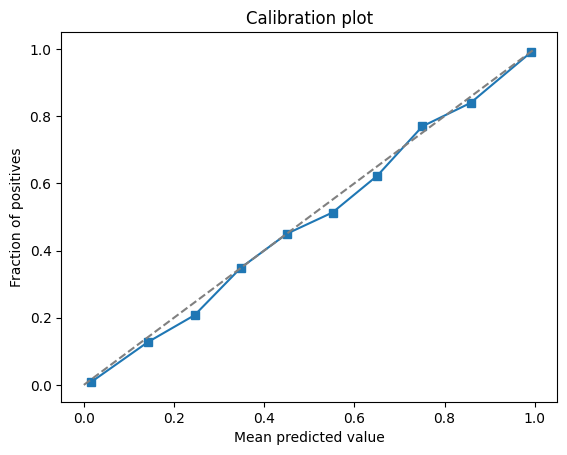

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_pos = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()

## Retagging with End-Model Predictions

Retagging uses predictions from an interim model—often trained on a portion of the data—to identify and correct annotation errors. By comparing these predictions with the existing labels, discrepancies can be flagged, which may indicate mislabeling or inconsistencies.

### Importance of Retagging

Weakly labeled data is common in tasks where high-quality annotations are difficult or expensive to obtain. Noisy labels can introduce errors in the training process and reduce model performance. Retagging improves label quality by:

- **Reducing Noise:** Updating labels based on reliable predictions helps reveal the true patterns in the data.
- **Improving Model Performance:** An enhanced dataset leads to better training for downstream models.
- **Efficiency:** It offers a flexible approach when manual re-annotation for large datasets is impractical.

> **Analogy:** Think of retagging like a spellchecker reviewing a document. The document (dataset) may have typos (label errors), and the spellchecker (model) suggests corrections. Reviewing these suggestions improves overall accuracy, much like retagging improves the quality of training data.

The process can be summarized as correcting the dataset so that it more accurately represents the fundamental class structure, leading to a refined model training process.


### Steps to Apply Retagging

To carry out retagging, consider the following steps:

1. **Train the Model on a Subset:**  
 Divide your dataset into subsets. Train the model using one subset to ensure that predictions for the remaining data are out-of-sample.

2. **Obtain Out-of-Sample Predictions:**  
 Use the trained model to generate predictions on the data that was not used during training. This practice reduces the risk of overfitting.

3. **Compare Predictions with Existing Labels:**  
 Identify instances where the model's predictions differ from the given labels. These differences signal potential annotation errors.

4. **Flag and Review Discrepancies:**  
 Treat the identified differences as candidates for correction. A systematic review—or even an iterative re-evaluation—can help decide whether to update the label.  

Mathematically, if $ y_i $ is the original label and $\hat{y}_i $ is the model's predicted probability for class membership, a flag might be raised when:

$$
|\hat{y}_i - y_i| > \epsilon
$$

where $epsilon $ is a chosen threshold reflecting acceptable variance.



### Practical Considerations

- **Model Confidence:**  
 When updating a label, consider the prediction confidence. High-confidence predictions are more likely to indicate actual errors and are safer to use for retagging.

- **Iterative Refinement:**  
 Retagging can be repeated. After updating labels, retrain the model and recompute predictions, which can further enhance the dataset quality.

- **Threshold Setting:**  
 Define thresholds for flagging discrepancies. For instance, only consider changes where:

  $$
  \hat{y}_i > p \quad \text{or} \quad \hat{y}_i <1-p
  $$

  with $ p $ as probability threshold (e.g., 0.9) to ensure adjustments are based on confident predictions.

- **Domain Expertise:**  
 Engage domain experts to review critical discrepancies. Their insight is valuable in ensuring that the retagging process aligns with real-world interpretations of the data.

- **Avoiding Overfitting:**  
 It is essential that the predictions used for retagging are out-of-sample. Cross-validation techniques are advisable, as they provide a more realistic model performance estimate across the entire dataset.

> **Note:** Retagging should be viewed as complement to manual annotation rather than a complete replacement. While it can correct many mistakes, there remains a risk of introducing new errors if the model makes incorrect predictions.

### Additional Resources

- For comparisons with other techniques on improving weak labels, consider reading [this study](https://arxiv.org/abs/2206.02280).  
- For a detailed description of the retagging approach and more background, refer to the original [Retag Paper](https://aclanthology.org/W00-1907/).


In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Initialize stratified k-fold cross-validation with 20 splits
# StratifiedKFold ensures that each fold has the same proportion of classes as the original dataset
cross_validation = StratifiedKFold(n_splits=20, shuffle=True, random_state=271828)

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_retag = LogisticRegression(
    random_state=271828, n_jobs=-1, class_weight="balanced"
)

# Perform cross-validated predictions on the training data
# 'method="predict"' returns the predicted class labels for each fold
# 'n_jobs=2' is a trick to use all available processors threads, as n_jobs in model_retag is already set to -1
y_train_retag = cross_val_predict(
    estimator=model_retag,
    X=X_train,
    y=y_train,
    cv=cross_validation,
    method="predict",
    n_jobs=2,
)

In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the training data
# y_train_retag is the re-tagged training labels obtained from cross-validation
model_lr.fit(X_train, y_train_retag)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95817
Balanced Accuracy Score:               0.95267
F1 Score (weighted):                   0.95826
Cohen Kappa Score:                     0.90124
Matthews Correlation Coefficient:      0.90130

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7871
           1       0.97      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 482 false negatives and 608 false positives.
Class 1 has 608 false negatives and 482 false positives.
The total number of errors is 1090 out of 26058 samples (error rate: 0.0418).
Predicted      0       1     All
True                            
0          7,389     482   7,871
1            608  17,579  18,187
All        7,997  18,0

In [9]:
# Dropping indexes where y_train_retag is different from y_train
# This step ensures that only the examples where the re-tagged labels match the original labels are kept
keep_indexes = (y_train_retag == y_train).values
X_train_retag = X_train[keep_indexes]
y_train_retag = y_train[keep_indexes]

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Fit the Logistic Regression model on the filtered training data
model_lr.fit(X_train_retag, y_train_retag)

# Predict the labels for the test set
y_test_pred = model_lr.predict(X_test)

print_classification_metrics(y_test, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.95875
Balanced Accuracy Score:               0.94984
F1 Score (weighted):                   0.95869
Cohen Kappa Score:                     0.90191
Matthews Correlation Coefficient:      0.90193

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7871
           1       0.97      0.97      0.97     18187

    accuracy                           0.96     26058
   macro avg       0.95      0.95      0.95     26058
weighted avg       0.96      0.96      0.96     26058


Confusion Matrix:

Class 0 has 572 false negatives and 503 false positives.
Class 1 has 503 false negatives and 572 false positives.
The total number of errors is 1075 out of 26058 samples (error rate: 0.0413).
Predicted      0       1     All
True                            
0          7,299     572   7,871
1            503  17,684  18,187
All        7,802  18,2

\
The table below summarizes the reduction in annotation errors achieved by applying retagging to the dataset. The retagging process uses model predictions to drop instances in the weakly annotated dataset, leading to a cleaner and more consistent set of training data.

| Dataset     | Errors | Improvement    |
|-------------|--------|----------------|
 WS          |1126   |                |
| WS + Retag  |1075   | **4.5%**       |

We can see hat the retagging process has reduced the total number of errors by approximately 4.5%, a significant enhancement given the straightforward nature of the approach.


### Retagging in Traditional Supervised Learning

While commonly associated with weak supervision, **retagging** can also be a valuable technique in traditional supervised learning. In this context, it involves using the predictions of an intermediate model to refine the original training labels, ultimately improving the quality of the dataset used to train the final model.

This process can be particularly helpful in addressing several common issues present in real-world datasets:

- **Annotation Errors:** Human annotators can make mistakes. An intermediate model can help identify and potentially correct these errors, leading to a more accurate gold standard.
- **Label Inconsistencies:** Large datasets annotated by multiple individuals can suffer from inconsistencies in label application. Retagging can help standardize labels and improve consistency.
- **Ambiguities:** Some data points may be inherently ambiguous or fall into gray areas within the labeling schema. Retagging can capitalize on the intermediate model's learned representations to potentially resolve these ambiguities more consistently.


## Introduction to Confident Learning

Confident Learning presents a systematic framework for training models in settings where data labels may be corrupted or noisy. Its central idea is to incorporate a **label noise transition matrix** that quantifies the likelihood of observed labels being different from the true labels. This technique improves model performance by explicitly accounting for mislabeled examples during training.

### Key Components of Confident Learning

#### 1. Label Noise Transition Matrix

- **Definition:**  
 The label noise transition matrix is a table that shows the probability of observing a specific label given the true basic label. In a binary classification task, for example, if the true label is "positive," the matrix provides probabilities for both "positive" (correct) and "negative" (incorrect) labels.

- **Mathematical Representation:**  
 Let $\hat{Q}(\tilde{y} \mid y^*)$ represent the transition probability, where $\tilde{y}$ is the observed (possibly noisy) label and $y^*$ is the true label. For example, the probability of correctly labeling a "bus" might be written as:
  
 $$
  \hat{Q}(\tilde{y}=\text{bus} \mid y^*=\text{bus})
  $$
  
 and the probability of a mislabel as:
  
 $$
  \hat{Q}(\tilde{y}=\text{car} \mid y^*=\text{bus})
  $$

- **Utility:**  
 By analyzing both diagonal elements (correct label assignments) and off-diagonal elements (mislabeling cases), this matrix provides insights into the nature of label errors. These insights allow for adjustments during training to reduce the negative impact of noise.

#### 2. Confidence Thresholding

- **Concept:**  
 Not every model prediction is equally reliable. Confidence thresholding sets a predetermined level, and only predictions exceeding this threshold are considered during training. This selective approach helps reduce the influence of data points that might be mislabeled.

- **Benefit:**  
 The method improves the learning process by focusing on predictions that the model is most certain about. It minimizes the risk of propagating errors from uncertain or noisy labels.

#### 3. Model-Agnostic Implementation

- **Flexibility:**  
 The framework does not depend on a particular type of model. Whether the model is simple or complex, such as logistic regression or a deep neural network, Confident Learning can be applied as long as the model outputs valid class probability estimates.

- **Implication:**  
 This broad applicability makes the method suitable for various domains and tasks, ensuring that the benefits from mitigating label noise can be reaped regardless of the model choice.

#### 4. Data-Centric Approach

- **Focus on Data Quality:**  
 Confident Learning emphasizes the improvement of data quality by directly addressing mislabeled instances. Correcting data quality at the source leads to models that generalize better and exhibit improved performance.

- **Implementation:**  
 The strategy involves examining the dataset for inconsistencies and refining the labeling process. It can also suggest adjustments in the data collection pipeline to minimize future errors.



### Detailed Example: Observed vs. True Labels

#### Confusion Matrix Example

Consider the following confusion matrix that represents counts of observed labels ($\tilde{y}$) versus true basic labels ($y^*$):

<div align="center">

| $C_{\tilde{y}, y^*}$            | $y^*=\text{bus}$ | $y^*=\text{car}$ | $y^*=\text{bike}$ |
|--------------------------------|----------------|----------------|----------------|
 $\tilde{y}=\text{bus}$           |90                 |35                 |25                  |
| $\tilde{y}=\text{car}$           |50                 |70                 |5                   |
| $\tilde{y}=\text{bike}$          |30                 |15                 |75                  |

</div>

When these counts are normalized, we obtain the transition matrix:

<div align="center">

| $\hat{Q}(\tilde{y} \mid y^*)$    | $y^*=\text{bus}$ | $y^*=\text{car}$ | $y^*=\text{bike}$ |
|--------------------------------|----------------|----------------|----------------|
 $\tilde{y}=\text{bus}$           |0.22               |0.09               |0.06                |
| $\tilde{y}=\text{car}$           |0.13               |0.18               |0.01                |
| $\tilde{y}=\text{bike}$          |0.08               |0.04               |0.19                |


</div>


#### Important Points from the Matrix

- **Diagonal Elements:**  
 Represent probabilities where the observed label equals the true label. For example, 
 $$
  \hat{Q}(\tilde{y}=\text{bus} \mid y^*=\text{bus}) =0.22
  $$
  indicates the chance that a true "bus" remains correctly labeled.

- **Off-Diagonal Elements:**  
 Represent mislabeling probabilities. For instance, 
 $$
  \hat{Q}(\tilde{y}=\text{car} \mid y^*=\text{bus}) =0.13
  $$
  denotes a 13% chance that a "bus" is misobserved as "car".




### Applications of the Transition Matrix

- **Error Detection:**  
 Analyzing off-diagonal entries clarifies which classes frequently get confused, guiding further review of the data labeling process.

- **Model Training with Noisy Data:**  
 The transition matrix informs algorithms that adjust for noisy labels. This knowledge can be integrated into the objective function or used to weight training examples differentially.

- **Data Quality Insight:**  
 Examining the probabilities helps to uncover fundamental issues in the dataset, such as overlapping classes or ambiguous definitions, prompting revisions to the labeling scheme.



### Estimating the Joint Distribution $P(\tilde{y}, y^*)$

#### Components Needed

- **Noisy labels ($\tilde{y}$)**:  
 These are the observed labels found in the dataset.

- **Predicted Probabilities ($\hat{p}(\tilde{y}; x, \theta)$)**:  
 These are the probabilities provided by the model for each class. Here, $x$ denotes the input data and $\theta$ represents the model parameters.

#### Obtaining Reliable Predictions

- **Out-of-Sample Predictions:**  
 It is important to obtain predictions from data that the model did not see during training. This can be done by applying cross-validation. The goal is to avoid overfitting the estimates of $\hat{p}(\tilde{y}; x, \theta)\ $ and ensure that the predictions are unbiased.

- **Statistical Estimation:**  
 Using out-of-sample predictions, one can derive the joint distribution $P(\tilde{y}, y^*)$ and subsequently compute marginal and conditional probabilities. For instance, the marginal probability of the observed label is given by:

  $$
  P(\tilde{y}) = \sum_{y^*} P(\tilde{y}, y^*)
  $$

  while the conditional probability, which is equivalent to the transition probability, is obtained by:

  $$
  P(\tilde{y} \mid y^*) = \frac{P(\tilde{y}, y^*)}{P(y^*)}
  $$

> **Additional Insight:**  
> Accurately estimating $P(\tilde{y}, y^*)$ aids in making informed adjustments during model training, especially when different classes are affected by varying levels of label noise.


For more detailed reading, refer to the [paper](https://arxiv.org/pdf191.00068).

In [15]:
from sklearn.linear_model import LogisticRegression

# Initialize stratified k-fold cross-validation with 20 splits
# StratifiedKFold ensures that each fold has the same proportion of classes as the original dataset
cross_validation = StratifiedKFold(n_splits=20, shuffle=True, random_state=271828)

# Initialize a Logistic Regression model with balanced class weights
# 'random_state' ensures reproducibility, 'n_jobs=-1' uses all available processors
model_lr = LogisticRegression(random_state=271828, n_jobs=-1, class_weight="balanced")

# Perform cross-validated predictions on the training data
# 'method="predict_proba"' returns the predicted probabilities for each class
# 'n_jobs=2' uses 2 processors for parallel computation
y_train_preds = cross_val_predict(
    estimator=model_lr,
    X=X_train,
    y=y_train,
    cv=cross_validation,
    method="predict_proba",
    n_jobs=2,
)

# Display the first 5 rows of the predicted probabilities
y_train_preds[:5]

array([[2.39681761e-01, 7.60318239e-01],
       [9.99920616e-01, 7.93838838e-05],
       [9.99949935e-01, 5.00646014e-05],
       [1.15700446e-02, 9.88429955e-01],
       [8.68763949e-01, 1.31236051e-01]])

#### Step 2: Computing Thresholded Confidences

**Fundamental Idea:**  To gauge the machine's innate confidence level for each task or class $j$, we establish class-specific thresholds. These thresholds serve as a practical measure for the machine's average self-confidence in its predictions related to each class.

The threshold $t_j$ for class $j$ is calculated using the following formula:

$$ t_j = \frac{1}{|X_{\tilde{y}=j}|} \sum_{x \in X_{\tilde{y}=j}} \hat{p}(\tilde{y} = j; x, \theta) $$

Let's break down each component of this formula to understand its meaning and purpose:

- **$t_j$:** This represents the **confidence threshold** specifically for class $j$.  It's a scalar value that quantifies the average confidence of the model when it *deals with data points that have a noisy label* of class $j$. Think of it as a baseline confidence level associated with noisy labels of class $j$.

- **$|X_{\tilde{y}=j}|$:** This denotes the **count of data points** in the dataset $X$ that are given the **noisy label** $j$.  Here, $X$ represents the entire dataset under consideration, and $\tilde{y}$ signifies the **noisy observed labels**. The notation $| \cdot |$ represents the cardinality or size of the set. So, we are counting how many data points in the *noisy labeled* dataset are labeled as class $j$.

- **$X_{\tilde{y}=j}$:**  This is the **set of data points** from the dataset $X$ that are **observed to have the noisy label** $j$.  In other words, it's the collection of all data instances $x$ that are given the noisy label $\tilde{y} = j$ in the dataset.

- **$\sum_{x \in X_{\tilde{y}=j}}$:** This is a **summation** performed over all data points $x$ within the set $X_{\tilde{y}=j}$.  We are iterating through each data point that has the noisy label $j$.

- **$\hat{p}(\tilde{y} = j; x, \theta)$:** This represents the **predicted probability** that a data point $x$ *should have the noisy label* $j$, as estimated by the model. This probability is conditional on the input data $x$ and the model's parameters $\theta$.  The model is trained on noisy labels $\tilde{y}$, and it learns to predict the probability distribution over these noisy labels.  So, $\hat{p}(\tilde{y} = j; x, \theta)$ is the model's assessment of how likely the noisy label should be $j$ for a given input $x$.


The formula essentially computes the average of the predicted probabilities associated with the noisy label $j$, specifically for those data points that are *given* the noisy label $j$ in the dataset. Let's unpack the process:

1. **Identify Data Points with Noisy Label $j$:** First, we gather all the data points that are *initially labeled as class $j$ in our noisy dataset*. This gives us the set $X_{\tilde{y}=j}$.

2. **Extract Confidence Scores for Noisy Label $j$:** For each data point in $X_{\tilde{y}=j}$, we look at the predicted probability $\hat{p}(\tilde{y} = j; x, \theta)$.  This value represents the model's "confidence" that the noisy label for this instance *should be* $j$, based on its training on the noisy dataset.

3. **Sum the Confidence Scores:** We sum up all these individual confidence scores for all data points in $X_{\tilde{y}=j}$. This provides a total confidence mass associated with noisy label $j$.

4. **Average the Confidence Scores:** Finally, we divide this sum by the total number of data points in $X_{\tilde{y}=j}$ (which is $|X_{\tilde{y}=j}|$). This averaging process gives us $t_j$, the average confidence score associated with the noisy label $j$.


##### Why Class-Specific Thresholds?

We need to calculate thresholds *per class* rather than using a single global threshold. This is because machine learning models trained on noisy data might exhibit varying levels of average confidence across different noisy label classes.  The level of noise might also vary across classes.

For example, consider image classification with noisy labels:

- **Noisy Label "Car":** For data points *labeled as* "car" (even if some are actually not cars), the model might still learn some features of cars and assign relatively high probabilities to the noisy label "car" for instances in $X_{\tilde{y}=\text{car}}$. The average confidence $t_{\text{car}}$ for the noisy label "car" will likely reflect the model's average confidence when dealing with data points *labeled* as "car".

- **Noisy Label "Bicycle":** Similarly, for data points *labeled as* "bicycle", the average confidence $t_{\text{bicycle}}$ for the noisy label "bicycle" will reflect the model's average confidence when dealing with data points *labeled* as "bicycle". This might be different from $t_{\text{car}}$ if the noise characteristics are different for "car" and "bicycle" noisy labels.

With class-specific thresholds, we account for these potential differences in model behavior and noise levels across different noisy labels.  This allows us to establish a more nuanced and accurate measure of the model's self-assessment for each noisy label class.

##### Threshold as a Proxy for Self-Confidence concerning Noisy Labels

It is important to understand that $t_j$ is a *proxy* for the machine's self-confidence *related to the noisy label $j$*. It's derived from the model's output probabilities when trained on noisy labels, and we interpret it as reflecting its average confidence level associated with each noisy label class. A higher $t_j$ suggests that, on average, the model is more "confident" in its predictions *related to the noisy label $j$*.

This threshold $t_j$, calculated for each noisy label class, will be used in subsequent steps to identify and potentially correct noisy labels based on the concept of confident learning.

In [16]:
# Calculate the threshold for the negative class based on the mean probability when the given label is negative
t_negative = y_train_preds[y_train == 0].mean(axis=0)[0]

# Calculate the threshold for the positive class based on the mean probability when the given label is positive
t_positive = y_train_preds[y_train == 1].mean(axis=0)[1]

# Print the calculated thresholds
print(f"Threshold for negative class: {t_negative:.4f}")
print(f"Threshold for positive class: {t_positive:.4f}")

Threshold for negative class: 0.9408
Threshold for positive class: 0.9424



#### Step 3: Compute the Error Sets

Following the computation of class-specific thresholds, the next  step is to pinpoint data points that are likely to be confidently misclassified *with respect to the observed noisy labels*. We achieve this by defining and computing **error sets**. These sets identify instances where the model's prediction suggests a different true class than the provided *noisy* label, and this suggestion is statistically significant based on our confidence thresholds.

The error set, denoted as $\hat{X}_{\tilde{y}=i, y^*=j}$, is formally defined as:

$$
\hat{X}_{\tilde{y}=i, y^*=j} = \{ x \in X_{\tilde{y}=i} : \hat{p}(\tilde{y} = j; x, \theta) \geq t_j \}
$$

Let's dissect each component of this definition to fully grasp its meaning:

- **$\hat{X}_{\tilde{y}=i, y^*=j}$**: This notation represents the **error set** itself. It is the set of data points $x$ that meet specific criteria indicative of a likely misclassification *where the noisy label is $i$ but the model suggests the true label might be $j$*. The subscripts $\tilde{y}=i, y^*=j$ are used to specify the conditions under which we are identifying these error sets:
    -  $\tilde{y}=i$ indicates that the data point $x$ is **initially given the noisy label** $i$ in the dataset.
    -  $y^*=j$ suggests that, despite the noisy label being $i$, there is strong evidence from the model pointing towards class $j$ being the *potential true* class label.  We use $y^*$ to conceptually represent the "true" label, although we don't know it directly in a noisy label scenario.

- **$X_{\tilde{y}=i}$**: This is the set of data points from Step 2, which comprises all data instances $x$ that are **initially labeled with the noisy label** $i$.  We are filtering data points *within* this set to identify potential noisy labels.

- **$\{ x \in X_{\tilde{y}=i} : \dots \}$**: This is set-builder notation. It reads as "the set of all $x$ belonging to $X_{\tilde{y}=i}$ such that the condition following the colon is true". In our case, the condition is:

    - **$\hat{p}(\tilde{y} = j; x, \theta) \geq t_j$**: This is the central condition for identifying potentially noisy labels. It states that for a data point $x$ (which has a *noisy label* $i$), we examine the predicted probability $\hat{p}(\tilde{y} = j; x, \theta)$. This probability is the model's estimation of how likely the *noisy label* should be $j$ for input $x$.  If this probability is greater than or equal to the threshold $t_j$ (computed for noisy label class $j$ in Step 2), then the condition is met.

##### Confident Indication of a Different True Class (Despite Noisy Label)

The condition $\hat{p}(\tilde{y} = j; x, \theta) \geq t_j$ is key to understanding how we identify potential noisy labels.

Let's break it down:

1.  **Starting with Noisy Label $i$:** We begin with data points that are *initially given the noisy label* $i$ in the dataset.

2.  **Considering a Different Potential True Class $j$:** For each of these instances with noisy label $i$, we look at the model's predicted probability $\hat{p}(\tilde{y} = j; x, \theta)$.  This represents the model's assessment of how likely the *noisy label* should be $j$ for the same input $x$. We are essentially asking: "Even though the noisy label is $i$, how likely, according to the model trained on noisy data, is it that the *noisy label should have been* $j$?".

3.  **Threshold Comparison: Confidence Check for Noisy Label $j$**: We then compare this probability $\hat{p}(\tilde{y} = j; x, \theta)$ with the threshold $t_j$. Recall that $t_j$ is the average confidence the model exhibits when dealing with data points that have the noisy label $j$.

4.  **Confident Suggestion of True Class $j$ (When Noisy Label is $i$)**: If $\hat{p}(\tilde{y} = j; x, \theta) \geq t_j$, it means that for a data point with *noisy label* $i$, the model assigns a probability to the *noisy label* $j$ that is *at least as high as* its average confidence associated with noisy label $j$.  This suggests that even though the provided noisy label is $i$, the model is indicating with significant confidence that the *true* label might actually correspond to class $j$.

##### Purpose of Error Sets

The primary purpose of computing these error sets is to:

- **Identify Likely Noisy Labels:** By finding data points that are *given* a noisy label ($i$) but for which the model indicates a high probability related to a *different* noisy label class ($j$), we pinpoint instances that are strong candidates for having incorrect noisy labels. These are not definitively mislabeled points, but rather data points that warrant closer inspection as potential sources of label noise. We suspect the provided noisy label $i$ might be incorrect and the true label is more likely to be associated with class $j$.

- **Estimate Noise Transitions:**  Error sets are needed for estimating the label noise transition matrix. Each error set $\hat{X}_{\tilde{y}=i, y^*=j}$ gives us an empirical count of how often instances *labeled as* class $i$ (noisy label) might actually have a true label corresponding to class $j$. By analyzing the sizes and compositions of these error sets for all pairs of classes $(i, j)$, we can begin to approximate the probabilities of transitioning from a true label to a noisy label (or more precisely, the relationship between noisy labels and true labels).


In [17]:
# Create boolean masks for negative and positive examples in the training data
negative_mask = y_train == 0  # Mask for negative examples (class 0)
positive_mask = y_train == 1  # Mask for positive examples (class 1)

# Get the indices of negative and positive examples using the masks
negative_indices = y_train[negative_mask].index  # Indices of negative examples
positive_indices = y_train[positive_mask].index  # Indices of positive examples

# Create boolean masks for negative and positive examples below their respective thresholds
# y_train_preds[negative_indices][:, 0] extracts the predicted probabilities for class 0 for negative examples
negative_below_threshold_mask = (
    y_train_preds[negative_indices][:, 0] < t_negative
)  # Mask for negative examples below threshold
# y_train_preds[positive_indices][:, 1] extracts the predicted probabilities for class 1 for positive examples
positive_below_threshold_mask = (
    y_train_preds[positive_indices][:, 1] < t_positive
)  # Mask for positive examples below threshold

# Get the indices of negative and positive examples that are below the threshold
negative_below_threshold_indices = negative_indices[
    negative_below_threshold_mask
]  # Indices of negative examples below threshold
positive_below_threshold_indices = positive_indices[
    positive_below_threshold_mask
]  # Indices of positive examples below threshold

# Get the indices of examples that are above the threshold for both classes
# This includes all indices that are not in negative_below_threshold_indices or positive_below_threshold_indices
above_threshold_indices = [
    i
    for i in range(len(y_train))
    if i not in negative_below_threshold_indices
    and i not in positive_below_threshold_indices
]

# Display the first 5 indices of negative examples below the threshold, positive examples below the threshold, and examples above the threshold
negative_below_threshold_indices[:5], positive_below_threshold_indices[
    :5
], above_threshold_indices[:10]

(Index([4, 17, 19, 59, 86], dtype='int64'),
 Index([0, 9, 20, 24, 26], dtype='int64'),
 [1, 2, 3, 5, 6, 7, 8, 10, 11, 12])

In [18]:
# Create the indices of negative examples below the threshold for class 0 but above the threshold for class 1
# This includes examples that are misclassified as negative examples
negative_misclassified_indices = [
    i for i in negative_below_threshold_indices if y_train_preds[i][1] > t_positive
]

# Create the indices of positive examples below the threshold for class 1 but above the threshold for class 0
# This includes examples that are misclassified as positive examples
positive_misclassified_indices = [
    i for i in positive_below_threshold_indices if y_train_preds[i][0] > t_negative
]

In [21]:
import numpy as np
import cleanlab

# Define mappings between integer labels and their string representations
int_to_str = {0: "Negative", 1: "Positive"}
str_to_int = {
    v: k for k, v in int_to_str.items()
}  # Reverse mapping from string to integer

num_classes = len(int_to_str)

# Calculate the threshold for each class based on the mean predicted probabilities
# This threshold will be used to determine the predicted class
thresholds = np.zeros(num_classes)
for k in range(num_classes):
    thresholds[k] = np.mean(y_train_preds[:, k][y_train == k])  # P(label^=k|label=k)


# Initialize a counts matrix to keep track of true vs predicted class counts
confident_joint_matrix = np.zeros((num_classes, num_classes))

# Iterate over each example to populate the confident joint matrix
for i, prob_row in enumerate(y_train_preds):
    observed_label = y_train[i]

    # Determine which classes the example is confidently labeled as
    confident_bins = prob_row >= thresholds - 1e-6
    num_confident_bins = sum(confident_bins)

    # If exactly one confident class, increment the count for that class
    if num_confident_bins == 1:
        confident_joint_matrix[observed_label][np.argmax(confident_bins)] += 1

    # If more than one confident class, increment the count for the class with the highest probability
    elif num_confident_bins > 1:
        confident_joint_matrix[observed_label][np.argmax(prob_row)] += 1

# Print the confident_joint_matrix without using scientific notation
np.set_printoptions(suppress=True)

confident_joint_matrix.astype(int)

array([[21038,    22],
       [  173, 61555]])

In [22]:
# We you can see, the number of confident predictions is much lower than the total number of examples. This is expected, as the model is not confident about all predictions, several instances are not confidently classified as either positive or negative.

int(confident_joint_matrix.sum()), len(y_train)

(82788, 101461)

In [23]:
# Normalize the confident joint matrix using Cleanlab's calibration function
# This function forces the confident joint to have the true noisy prior p(labels) (summed over columns for each row), making it a valid counts estimate of the actual joint of noisy and true labels

confident_joint_matrix = cleanlab.count.calibrate_confident_joint(
    confident_joint_matrix, y_train
)

# Display the normalized confident joint matrix
confident_joint_matrix

array([[27575,    29],
       [  207, 73650]])

In [24]:
int(
    confident_joint_matrix.sum()
)  # Now the sum of the confident joint matrix is equal to the number of examples in the training data

101461

In [27]:
# Define ANSI color codes
RED = "\033[31m"
GREEN = "\033[32m"
RESET = "\033[0m"

# Combine indices of examples below the threshold and above the threshold
# Select the first 5 examples from each category for demonstration
example_indices = list(negative_misclassified_indices[:5]) + list(
    positive_misclassified_indices[:5]
)

# Print the threshold for each class
for class_idx, class_name in int_to_str.items():
    if class_name == "Negative":
        colored_name = f"{RED}{class_name}{RESET}"
    elif class_name == "Positive":
        colored_name = f"{GREEN}{class_name}{RESET}"
    else:
        colored_name = class_name
    print(f"Threshold for class {colored_name}: {thresholds[class_idx]:.4f}")

print("\n\n")
print("-" * 50)

# Iterate over the selected example indices
for idx in example_indices:
    # Get the true label and predicted confidence scores for the current example
    observed_label = y_train[idx]
    confidence_scores = y_train_preds[idx]

    # Print the index and text of the current example
    print(f"Index: {idx}")
    print(f'Text: "{df_train.loc[idx, "text"]}"')

    if int_to_str[observed_label] == "Negative":
        label = f"{RED}{int_to_str[observed_label]}{RESET}"
    elif int_to_str[observed_label] == "Positive":
        label = f"{GREEN}{int_to_str[observed_label]}{RESET}"
    else:
        label = int_to_str[observed_label]

    print(f"Given Label: {label}")

    predicted_class = None

    # Print confidence scores for each class and determine the predicted class
    for i, confidence_score in enumerate(confidence_scores):
        class_name = int_to_str[i]
        if class_name == "Negative":
            colored_class = f"{RED}{class_name}{RESET}"
        elif class_name == "Positive":
            colored_class = f"{GREEN}{class_name}{RESET}"
        else:
            colored_class = class_name

        output_str = f"Confidence score for class {class_name}: {confidence_score:.4f}"
        if confidence_score >= thresholds[i]:
            predicted_class = i
            output_str += " (Threshold met)"
        else:
            output_str += " (Threshold not met)"
        print(output_str)

    # Print the predicted class
    if predicted_class is not None:
        pred_class_name = int_to_str[predicted_class]
        if pred_class_name == "Negative":
            pred_class = f"{RED}{pred_class_name}{RESET}"
        elif pred_class_name == "Positive":
            pred_class = f"{GREEN}{pred_class_name}{RESET}"
        else:
            pred_class = pred_class_name
        print(f"Predicted class: {pred_class}\n")
    else:
        print("Predicted class: None\n")
    print("-" * 50)

Threshold for class Negative: 0.9408
Threshold for class Positive: 0.9424



--------------------------------------------------
Index: 1505
Text: "otima - esta querendo enganar a quem e golpe golpe golpe golpe golpe"
Given Label: Negative
Confidence score for class Negative: 0.0239 (Threshold not met)
Confidence score for class Positive: 0.9761 (Threshold met)
Predicted class: Positive

--------------------------------------------------
Index: 16382
Text: "potente e leve - o tamanho e grande, porem bastante leve, tem processamento muito rapido, muito espaco na memoria interna, rom de 64 gb, sobra uns 52gb com o sistema instalado, alem dos 4 gb de ram mais que da, sobra, o corpo do aparelho passa uma certa impressao de fragilidade do material e a bateria poderia ser de pelo menos uns 4.000 ma, mas o carregamento rapido dela faz a sua compensacao."
Given Label: Negative
Confidence score for class Negative: 0.0489 (Threshold not met)
Confidence score for class Positive: 0.9511 (Threshold 

In [29]:
import numpy as np
import pandas as pd


def counts_matrix_to_dataframe(confusion_matrix, labels, name="C_{ŷ,y*}"):
    # Convert the confusion matrix (a numpy array) into a pandas DataFrame
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    # Set the name of the index to the provided name (default is 'C_{ŷ,y*}')
    df.index.name = name
    return df


# Define the labels for the confusion matrix, corresponding to the classes
labels = ["negative", "positive"]

# Convert the counts matrix (confusion matrix) to a pandas DataFrame for better readability
df_counts_matrix = counts_matrix_to_dataframe(confident_joint_matrix, labels)

# Display the DataFrame to visualize the confusion matrix
df_counts_matrix

,negative,positive
"C_{ŷ,y*}",,
negative,27575,29
positive,207,73650


In [30]:
counts_matrix_to_dataframe(
    confident_joint_matrix / confident_joint_matrix.sum(), labels, name="Q̂_{ŷ,y*}"
)

,negative,positive
"Q̂_{ŷ,y*}",,
negative,0.271779,0.000286
positive,0.002040,0.725895


## The Pervasiveness and Impact of Label Noise in Real-World Datasets

Label noise refers to errors or inaccuracies the assigned labels within a dataset. Research by [Northcutt et al., 2021](http://arxiv.org/abs/2103.14749) highlights that label noise is common in both training and test sets, and it can significantly affect the performance of machine learning models. A method known as **Confident Learning** was used in the study to estimate the amount of mislabeled data and to assess its impact.

### Prevalence of Label Noise in Popular Datasets

The study examined several widely used datasets and found a range of noise levels. The table below summarizes key findings:

<div align="center">

| Dataset        | CL Guessed | MTurk Checked | Validated Errors | Estimated Errors | % Error |
|----------------|------------|----------------|----------------|----------------|----------|
 MNIST          |100        |100 (100%)     |15               | —                |0.15%    |
| CIFAR-10       |275        |275 (100%)     |54               | —                |0.54%    |
| CIFAR-100      |2,235      |2,235 (100%)   |585              | —                |5.85%    |
| Caltech-256    |4,643      |400 (8.6%)     |65               |754              |2.46%    |
| ImageNet\*     |5,440      |5,440 (100%)   |2,916            | —                |5.83%    |
| QuickDraw      |6,825,383  |2,500 (0.04%)  |1,870            |5,105,386        |10.12%   |
| 20news         |93         |93 (100%)      |82               | —                |1.11%    |
| IMDB           |1,310      |1,310 (100%)   |725              | —                |2.90%    |
| Amazon         |533,249    |1,000 (0.2%)   |732              |390,338          |3.90%    |
| AudioSet       |307        |307 (100%)     |275              | —                |1.35%    |

</div>

*Notes:*
- **CL Guessed:** Number of samples suspected to be mislabeled by the Confident Learning method.
- **MTurk Checked:** Number of samples verified by human annotators using Amazon Mechanical Turk.

**Key Points:**

- Even datasets viewed as highly reliable, such as MNIST, contain mislabeled samples.
- The percentage of label noise varies sharply across different datasets, ranging from0.15% to over10%.
- In larger datasets, the absolute number of label errors can be very high even if the percentage appears moderate.


### Impact on Model Performance

Label noise can significantly influence a model’s behavior:

- **Learning Incorrect Associations:** When incorrect labels are present, models may develop erroneous relationships between features and labels.
- **Reduced Prediction Accuracy:** The presence of mislabeled examples can lower accuracy on both the training set and unseen data.
- **Overfitting on Noise:** Models may start fitting the noise instead of learning meaningful patterns, which is particularly harmful when the training data is noisy.

*Example:* If images of cats are mistakenly labeled as dogs, the model might learn features for dogs that do not represent the true characteristics of the class, leading to poor classification performance when encountering new images.

### Repercussions of Label Noise in Test Sets

Label noise affects test data and has several drawbacks:

- **Skewed Performance Metrics:** Evaluation metrics like accuracy or F1 score become less reliable when the test set contains labeling errors.
- **Faulty Model Comparisons:** Using noisy test data for model comparisons might result in favoring models that perform well on mislabeled samples rather than those that capture true basic patterns.
- **Misleading Assessment:** Relying on test results with significant noise might lead to an inflated sense of the model’s capabilities.

*Analogy:* Consider an exam where some of the answer choices are incorrectly marked. A student’s score measured against such an answer key would not accurately reflect their true mastery of the subject.

### Common Misconceptions

- **Significance of Minor Noise:** Even a small percentage of mislabeled data can have a large impact, especially in critical applications such as medical diagnosis.
- **Model Robustness:** While some algorithms may exhibit strength to random noise, they can still be misled if the noise is non-random or systematic. Real-world label noise often follows non-random patterns.
- **Cost of Data Cleaning:** Investing resources in improving data quality through cleaning and validation typically reduces overall effort later in the modeling process by decreasing the need for compensatory mechanisms in model training.



## Takeaways

- High-quality, accurately labeled data is essential for building effective machine learning models. Investing in techniques like AED and retagging can dramatically improve model reliability.

- Recognizing that label noise can be uniform, systematic, or instance-dependent encourages the use of tailored noise mitigation strategies. A nuanced approach to noise allows for better design of cleaning and training pipelines.

- Incorporating measures of model confidence and calibration into noise detection provides a quantitative basis for flagging potential errors. This helps automate the data refinement process and informs decisions about manual review.

- Rather than solely relying on more complex models to overcome noise, improving the training data through methods such as retagging and confident learning can lead to better model performance and more informative evaluation metrics.

- The process of identifying, correcting, and re-evaluating noisy labels should be viewed as iterative. Continually refining the dataset helps ensure that both training and test data accurately reflect the true basic patterns.

- Even highly regarded datasets (e.g., MNIST, ImageNet) can suffer from label noise, which means that reliable noise-handling methods are vital for realistic, generalizable models. Correcting these errors not only boosts performance but also leads to more trustworthy model evaluations.

# Questions

1. What is Annotation Error Detection (AED) and why is it important in improving dataset quality?

2. What are the three main types of label noise discussed in the notebook, and how do they differ?

3. How is the label noise transition matrix defined, and what is its role in handling noisy labels?

4. What is the retagging approach, and how does it help in refining the quality of training data?

5. How does the notebook explain the use of model confidence and class-specific thresholds for flagging annotation errors?

6. What are the key differences between data-centric methods and model-centric methods for handling label noise?

7. How are calibration plots used in this notebook to assess the reliability of model predictions?

8. What challenges does AED face in detecting annotation errors according to the notebook?

9. How does the notebook mathematically define an error set using predicted probabilities and thresholds?

10. What is Confident Learning, and how does the transition matrix factor into mitigating the impact of label noise?

`Answers are commented inside this cell.`
<!-- 

1. AED is the process of systematically identifying mislabeled or inconsistent examples in a dataset. It is crucial because it helps improve the quality of training data by detecting and correcting annotation errors, ultimately leading to more reliable and accurate machine learning models.

2. The notebook discusses three types of label noise: Uniform (Symmetric) noise where each mislabel is equally likely, Systematic (Asymmetric) noise where some classes are more likely to be confused than others, and Instance-Dependent noise where the probability of mislabeling depends on specific attributes of each instance.

3. The label noise transition matrix quantifies the probability of observing a noisy label given the true label. Mathematically, it is defined as p(𝑦̃ = i | y* = j) = C₍𝑦̃=i, y*=j₎ / C₍y*=j₎. This matrix is essential for methods like Confident Learning as it aids in adjusting for label noise during model training.

4. Retagging is an approach that uses predictions from an out-of-sample model to verify and potentially correct the existing labels. By comparing model outputs with the given (weak) labels, instances with high discrepancies are flagged, resulting in a refined and cleaner training dataset.

5. In the notebook, model confidence is quantified through predicted probabilities. Class-specific thresholds are computed as the average predicted probability for data points with a given noisy label. These thresholds help to flag instances when the model's confidence for a different label exceeds the average, indicating potential mislabeling.

6. Data-centric methods focus on improving the quality of the training data itself by identifying and cleaning mislabeled examples, whereas model-centric methods modify the model’s training process—for example, by changing the loss function—to be reliable to noise.

7. Calibration plots are used to compare the model’s predicted probabilities against the actual fraction of positives. By plotting mean predicted values against the actual positive fraction, one can visually assess how well the model's confidence scores are calibrated to reflect true likelihoods.

8. AED faces several challenges including the lack of ground truth labels, class imbalance (since correct labels typically outnumber label errors), domain-specific complexities, and the difficulty of distinguishing true errors from ambiguous cases.

9. The notebook defines an error set mathematically as 𝑋̂₍𝑦̃=i, y*=j₎ = { x ∈ X₍𝑦̃=i₎ : p̂(𝑦̃ = j; x, θ) ≥ t_j }, where t_j is the class-specific threshold. This set contains instances that are labeled as class i but for which the model's predicted probability for class j meets or exceeds the threshold, suggesting a likely mislabel.

10. Confident Learning is a framework that uses estimated joint probabilities and label noise transition matrices to account for and mitigate label noise. The transition matrix, which provides the likelihood of each observed label given the true label, is used to adjust training processes and improve the reliability of the model by systematically targeting mislabeled instances. -->